In [1]:
import numpy as np
import pandas as pd

In [2]:
from aux_plt import *

In [3]:
df = pd.read_csv("RESULTS1.csv.gz", compression='gzip', header=None)
CN = ["ID", "D", "SEED", "a0", "b0", "c0", "d0", "NITER", "LR", "K", "S", "SY", "E", "V", "LAMBDA",
      "iteration", "elapsed", "ct", "rt", "cb", "rb", "loss", "Et", "Vt", "Ee", "Ve", 
      "best_loss", "best_a", "best_b", "best_c", "best_d", "best_E", "best_V", "failed"]
df.rename(columns=dict(enumerate(CN)), inplace=True)
df = df.dropna(axis=0) # NAs!
df

,ID,D,SEED,a0,b0,c0,d0,NITER,LR,K,...,Ee,Ve,best_loss,best_a,best_b,best_c,best_d,best_E,best_V,failed
0,0.csv:0,E,0,0.1,1.0,0.1,1.0,20001,0.1,25,...,0.2281,0.416270,9.549003e+01,0.100000,1.000000,0.100000,1.000000,0.250000,0.550000,False
1,0.csv:0,E,0,0.1,1.0,0.1,1.0,20001,0.1,25,...,0.3024,0.523354,9.404345e+01,0.143679,1.306663,0.143679,1.306662,0.302272,0.530186,False
2,0.csv:0,E,0,0.1,1.0,0.1,1.0,20001,0.1,25,...,0.3754,0.561475,9.263293e+01,0.196701,1.627559,0.206532,1.708787,0.365181,0.549434,False
3,0.csv:0,E,0,0.1,1.0,0.1,1.0,20001,0.1,25,...,0.4300,0.580100,9.158490e+01,0.254647,1.917757,0.286512,2.157558,0.440824,0.605017,False
4,0.csv:0,E,0,0.1,1.0,0.1,1.0,20001,0.1,25,...,0.5186,0.673054,8.989695e+01,0.321725,2.205905,0.391755,2.685830,0.531831,0.685642,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135659,9.csv:9,E,9,0.1,1.0,0.1,1.0,1020,0.1,25,...,10.0145,10.099290,1.000000e-08,10.796210,17.059919,11.170623,17.628336,10.025371,10.790991,False
135660,9.csv:9,E,9,0.1,1.0,0.1,1.0,1020,0.1,25,...,10.0068,10.216354,1.000000e-08,10.796210,17.059919,11.170623,17.628336,10.025371,10.790991,False
135661,9.csv:9,E,9,0.1,1.0,0.1,1.0,1020,0.1,25,...,10.0799,10.450316,1.000000e-08,10.796210,17.059919,11.170623,17.628336,10.025371,10.790991,False
135662,9.csv:9,E,9,0.1,1.0,0.1,1.0,1020,0.1,25,...,9.8735,10.092498,1.000000e-08,10.796210,17.059919,11.170623,17.628336,10.025371,10.790991,False


In [4]:
df["Et"] = df["best_E"]
df["Vt"] = df["best_V"]

In [5]:
df_raw = df

# Auxiliary preprocessing & plotting code

In [6]:
f = lambda x: r"$10^3$" if x==1000 else "$%s$" % x 

In [7]:
def dfs(df, a0, b0, c0, d0, E=-1, V=-1, LAMBDA=0.0):  
    d1 = df[(df.LAMBDA==0.0) & (df.V==V) & (df.E==E)]
    d1 = d1.drop(columns=["failed"])

    d11 = d1[(d1.a0==a0)&(d1.b0==b0)&(d1.c0==c0)&(d1.d0==d0)]
    #print("a0=%s b0=%s c0=%s d0=%s => %s" % (a0,b0,c0,d0, len(d11)))

    means = d11.groupby(["iteration"]).mean().reset_index()
    stds = d11.groupby(["iteration"]).std().reset_index()
    assert (means.iteration == stds.iteration).all()
    return means, stds

In [8]:
from matplotlib.collections import LineCollection


def coloredline(x, y, colors=None, cmin=None, cmax=None, lw=2.5, cmap="Reds", alpha=1.0, log=True):
    assert (x>0).all()
    assert (y>0).all()
    
    colors = np.array(range(len(means))) if colors is None else np.array(colors)
    if log and colors.min()==0: colors = colors + 1

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors    
    cmin=colors.min() if cmin is None else cmin
    cmax=colors.max() if cmax is None else cmax    
    norm = mpl.colors.LogNorm(cmin,cmax) if log else plt.Normalize(cmin, cmax)     
    
    
    lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=alpha)
    # Set the values used for colormapping
    lc.set_array(colors)
    lc.set_linewidth(lw)
    line = plt.gca().add_collection(lc)
    return line

In [9]:
def musigma2abcd(mut, sigmat, mub, sigmab):    
    a,b = (mut*mut)/(sigmat*sigmat), mut/(sigmat*sigmat)
    c,d = (mub*mub)/(sigmab*sigmab), mub/(sigmab*sigmab)
    return a, b, c, d

def abcd2musigma(a, b, c, d, env=np):    
    return a/b, env.sqrt(a)/b, c/d, env.sqrt(c)/d

In [10]:
K = 25

def theoretical_moments(ct, rt, cb, rb):
    mt, st = ct/rt, np.sqrt(ct) / rt
    mb, sb = cb/rb, np.sqrt(cb) / rb
    e, var = K * mt*mb, K * (mt*mb + (mb*st)**2 + (mt*sb)**2 + (st*sb)**2)  # theoretical         
    return e, var

# Configuration

In [11]:
CFGS = [ (10, 1, 10, 1), (10,2,10,2),
        (0.001, 0.01, 0.01, 0.1),(0.1, 1, 0.1, 1), 
        (0.1, 0.1, 0.1, 0.1), (1, 1, 0.1, 0.1), (1000, 1000, 1000, 1000),
         ]


LABELS = ["A", "B", "C", "D", "E", "F", "G"]
SCALES = [ 'Purples_r','YlOrBr_r', 
          'Reds_r', 'Blues_r', 'Greens_r', 'Oranges_r',  'Greys_r', 
          
          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
           'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
COLORS2 = ["purple",  "brown",
          "red", "dodgerblue", "green", "orange", "gray", 
           ]
COLORS1 = ["violet",  "maroon",
          "salmon", "dodgerblue", "yellowgreen",  "orange", "gray", 
          ]

# 1D Plots

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
COLORS = COLORS1
s = lambda x: x #np.array(running_mean(np.array(x), 10))

0) A) a0=10 b0=1 c0=10 d0=1 d11=2559
1) B) a0=10 b0=2 c0=10 d0=2 d11=1549
2) C) a0=0.001 b0=0.01 c0=0.01 d0=0.1 d11=1076
3) D) a0=0.1 b0=1 c0=0.1 d0=1 d11=1190
4) E) a0=0.1 b0=0.1 c0=0.1 d0=0.1 d11=1199
5) F) a0=1 b0=1 c0=0.1 d0=0.1 d11=1191
6) G) a0=1000 b0=1000 c0=1000 d0=1000 d11=1190
----------------------
0) A) a0=10 b0=1 c0=10 d0=1 d11=1362
1) B) a0=10 b0=2 c0=10 d0=2 d11=1202
2) C) a0=0.001 b0=0.01 c0=0.01 d0=0.1 d11=1077
3) D) a0=0.1 b0=1 c0=0.1 d0=1 d11=1190
4) E) a0=0.1 b0=0.1 c0=0.1 d0=0.1 d11=1190
5) F) a0=1 b0=1 c0=0.1 d0=0.1 d11=1190
6) G) a0=1000 b0=1000 c0=1000 d0=1000 d11=1190


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


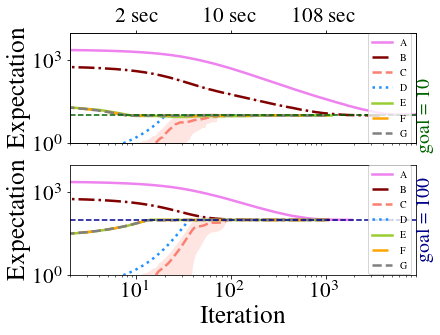

In [14]:
    COLNAME = "Et"
    XLABEL, XMIN, XMAX, XCOL = "Iteration", 2, 9000, "iteration"
    #XLABEL, XMIN, XMAX, XCOL = "Time [s]",  1e-3,100, "elapsed"
    alpha = 0.2
    LS = ["-", "-.", "--", "dotted"]
      
    start_plotting(cmbright=False)
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    
    E, V = 10, -1
    d1 = df[(df.LAMBDA==0.0) & (df.E==E) & (df.V==V)]
    d1 = d1.drop(columns=["failed"])    
    plt.sca(ax1)
    for i, (a0,b0,c0,d0) in enumerate(CFGS):  
        d11 = d1[(d1.a0==a0)&(d1.b0==b0)&(d1.c0==c0)&(d1.d0==d0)]
        
        means = d11.groupby(["iteration"]).mean().reset_index()
        stds = d11.groupby(["iteration"]).std().reset_index()
        assert (means.iteration == stds.iteration).all()
        iteration = means[XCOL]
        
        print("%i) %s) a0=%s b0=%s c0=%s d0=%s d11=%s" % (i, LABELS[i], a0,b0,c0,d0, len(d11)))
        errorfill((iteration), s(means[COLNAME]), s(stds[COLNAME]), color=COLORS[i], label=LABELS[i],
                  lw=2.5, alpha_fill=alpha, ls=LS[i%len(LS)])
        
        
    plt.ylabel(r"Expectation")
    goal = means["E"][0]
    plt.axhline(goal, lw=1.5, color="darkgreen", ls="--")
    
    plt.xlim(XMIN,XMAX)
    plt.xscale("log")
    plt.ylim(1,10000)
    plt.yscale("log")
    plt.xticks([],[])
    plt.legend(fontsize=10, loc=5)

    x1,x2 = plt.xlim()
    plt.text(x2*0.98, goal, "goal = %s" % E, ha="left", va="center", 
             color="darkgreen",  alpha=1.0, fontsize=20, rotation=90)    
    
    
    axT = plt.gca().twiny()
    axT.set_xlim(XMIN,XMAX)
    axT.set_xscale("log")    
    time10 = df[df.iteration==10]["elapsed"].mean()
    time100 = df[df.iteration==100]["elapsed"].mean()
    time1000 = df[df.iteration==1000]["elapsed"].mean()
    axT.set_xticks([10,100,1000])
    axT.set_xticklabels([str(round(time10))+" sec", str(round(time100))+" sec",str(round(time1000))+" sec"])
    axT.tick_params(which='minor', length=0)
    
    print("----------------------")
        
    E, V = 100, -1        
    d1 = df[(df.LAMBDA==0.0) & (df.E==E) & (df.V==V)]
    d1 = d1.drop(columns=["failed"])    
    plt.sca(ax2)
    for i, (a0,b0,c0,d0) in enumerate(CFGS):  
        d11 = d1[(d1.a0==a0)&(d1.b0==b0)&(d1.c0==c0)&(d1.d0==d0)]
        print("%i) %s) a0=%s b0=%s c0=%s d0=%s d11=%s" % (i, LABELS[i], a0,b0,c0,d0, len(d11)))
        if len(d11)<=0: continue
        
        means = d11.groupby(["iteration"]).mean().reset_index()
        stds = d11.groupby(["iteration"]).std().reset_index()
        assert (means.iteration == stds.iteration).all()
        iteration = means[XCOL]
        
        
        errorfill((iteration), s(means[COLNAME]), s(stds[COLNAME]), color=COLORS[i], label=LABELS[i],
                  lw=2.5, alpha_fill=alpha, ls=LS[i%len(LS)])
            
    plt.xlabel(XLABEL)
    plt.ylabel(r"Expectation")
    goal = means["E"][0]
    plt.axhline(goal, lw=1.5, color="darkblue", ls="--")
    plt.legend(fontsize=10, loc=5)
    
    plt.xlim(XMIN,XMAX)
    plt.xscale("log")
    plt.ylim(1,10000)
    plt.yscale("log")
    
    x1,x2 = plt.xlim()
    plt.text(x2*0.98, goal, "goal = %s" % E, ha="left", va="center", 
             color="darkblue",  alpha=1.0, fontsize=20, rotation=90)    
    
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)    
    plt.savefig("convergence_1D_EE.pdf")
    plt.show()